# Environment Check

First, ensure that Numba can interact with CUDA on your system:

In [1]:
!numba -s | grep -i cuda

__CUDA Information__
CUDA Device Initialized                       : True
CUDA Driver Version                           : 12.0
CUDA Runtime Version                          : 11.8
CUDA NVIDIA Bindings Available                : False
CUDA NVIDIA Bindings In Use                   : False
CUDA Minor Version Compatibility Available    : False
CUDA Minor Version Compatibility Needed       : False
CUDA Minor Version Compatibility In Use       : False
CUDA Detect Output:
Found 2 CUDA devices
CUDA Libraries Test Output:
	libcuda.so
	libcuda.so.1
	/usr/lib/libcuda.so
	/usr/lib/libcuda.so.1
	/usr/lib64/libcuda.so
	/usr/lib64/libcuda.so.1
		Loaded from libcuda.so
	Mapped libcuda.so paths:
		/usr/lib/x86_64-linux-gnu/nvidia/current/libcuda.so.525.125.06
Finding cudart from Conda environment
	Located at /home/ruequera/miniconda3/envs/gpu-lunch/lib/libcudart.so.11.8.89
Finding cudadevrt from Conda environment
	Located at /home/ruequera/miniconda3/envs/gpu-lunch/lib/libcudadevrt.a
cudatoolkit       

If there's no output, you might need to set the `CUDA_HOME` environment variable or install the necessary CUDA toolkit.

# Writing Your First CUDA Kernel

Let's start by creating a simple kernel to perform grayscale conversion on an image.

Import Libraries

In [2]:
import numpy as np
import numba.cuda as cuda
from skimage import io
import matplotlib.pyplot as plt

# Load an Image

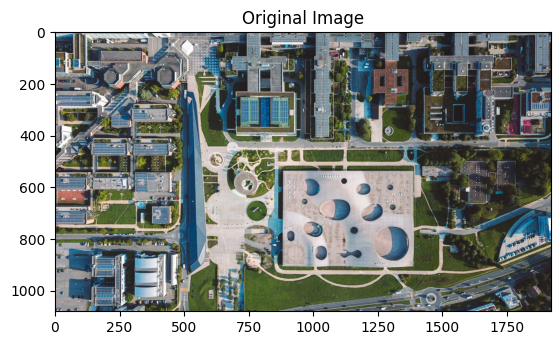

In [3]:
image = io.imread('EPFL_aereal.jpeg')
plt.imshow(image)
plt.title('Original Image')
plt.show()

Grayscale Conversion Kernel
This kernel converts an RGB image to grayscale by applying the luminosity method.

In [4]:
@cuda.jit
def rgb2gray_kernel(d_result, d_image):
    x, y = cuda.grid(2)
    if x < d_image.shape[0] and y < d_image.shape[1]:
        r, g, b = d_image[x, y]
        # Luminosity method: 0.21 R + 0.72 G + 0.07 B
        gray = 0.21 * r + 0.72 * g + 0.07 * b
        d_result[x, y] = gray

# Memory Management
Transfer data to the GPU.

In [5]:
d_image = cuda.to_device(image)
d_result = cuda.device_array(image.shape[:2], dtype=np.uint8)

# Kernel Invocation
Define the size of blocks and grid.

In [6]:
threadsperblock = (16, 16)
blockspergrid_x = int(np.ceil(image.shape[0] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(image.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

rgb2gray_kernel[blockspergrid, threadsperblock](d_result, d_image)

# Retrieve Data from GPU

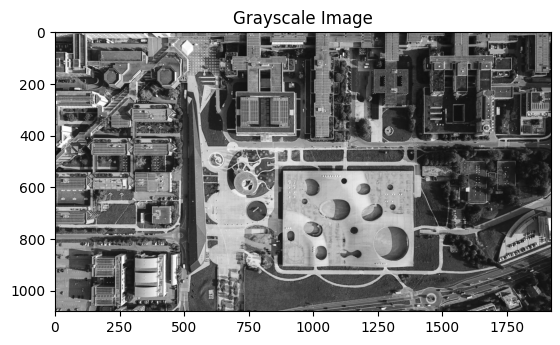

In [7]:
grayscale_image = d_result.copy_to_host()
plt.imshow(grayscale_image, cmap='gray')
plt.title('Grayscale Image')
plt.show()

# Measuring Performance
First, import the time module for CPU timing:

In [8]:
import time

## CPU Grayscale Conversion
Let’s implement a CPU version of the grayscale conversion to compare performance:

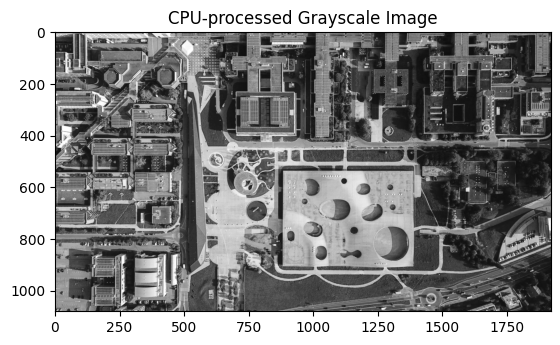

CPU Time: 8.29121 seconds


In [9]:

def rgb2gray_cpu(result, image):    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r, g, b = image[i, j]
            result[i, j] = int(0.21 * r + 0.72 * g + 0.07 * b)
    return result

# Measure CPU time
grayscale = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

start_time = time.perf_counter()
cpu_gray = rgb2gray_cpu(grayscale, image)
cpu_time = time.perf_counter() - start_time

plt.imshow(cpu_gray, cmap='gray')
plt.title('CPU-processed Grayscale Image')
plt.show()

print(f"CPU Time: {cpu_time:.5f} seconds")

In [10]:
def rgb2gray_cpu_numpy(result, image):    
    result[...] = (0.21 * image[..., 0] + 0.72 * image[..., 1] + 0.07 * image[..., 2]).astype(int)
    return result

# Measure CPU Numpy time
grayscale = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
start_time = time.perf_counter()
cpu_np_gray = rgb2gray_cpu_numpy(grayscale, image)
cpu_np_time = time.perf_counter() - start_time

print(f"CPU Time (Numpy): {cpu_np_time:.5f} seconds")

CPU Time (Numpy): 0.04332 seconds


In [11]:
from numba import njit 
@njit
def rgb2gray_numba(result, image):    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r, g, b = image[i, j]
            result[i, j] = int(0.21 * r + 0.72 * g + 0.07 * b)
    return result

# Measure CPU Numba time
grayscale = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

cpu_gray = rgb2gray_numba(grayscale, image)
start_time = time.perf_counter()
cpu_gray = rgb2gray_numba(grayscale, image)
cpu_numba_time = time.perf_counter() - start_time

print(f"CPU Time: {cpu_numba_time:.5f} seconds")

CPU Time: 0.00283 seconds


## GPU Performance Measurement
For GPU performance, we use Numba's CUDA event system to measure kernel execution time:

In [12]:
start_event = cuda.event()
end_event = cuda.event()

start_event.record()
rgb2gray_kernel[blockspergrid, threadsperblock](d_result, d_image)
end_event.record()
end_event.synchronize()  # Wait for the event to be executed!

gpu_time = cuda.event_elapsed_time(start_event, end_event) / 1000.0  # Convert milliseconds to seconds
print(f"GPU Time: {gpu_time:.5f} seconds")

GPU Time: 0.00071 seconds


Comparison
Finally, let's compare the times:

In [14]:
print(f"Speedup: {cpu_time / gpu_time:.2f}x")
print(f"Speedup: {cpu_numba_time / gpu_time:.2f}x")

Speedup: 11657.53x
Speedup: 3.98x


# Exercise
Modify the kernel to apply a different image processing effect, such as a blur or edge detection. Consider how data is managed and transferred between the host and device.

In [27]:
host_image = io.imread('EPFL_aereal.jpeg')

# Time transfer CPU->GPU
start_event = cuda.event()
end_event = cuda.event()

start_event.record()
device_image = cuda.to_device(host_image)
end_event.record()
end_event.synchronize() 
transfer_cpu_gpu_time = cuda.event_elapsed_time(start_event, end_event) / 1000.0  


# Generate output
device_result = cuda.device_array_like(device_image)


# Time transder GPU->CPU
start_time = time.perf_counter()
host_result = device_result.copy_to_host()
transfer_gpu_cpu_time = time.perf_counter() - start_time

print(f"CPU -> GPU: {transfer_cpu_gpu_time:.5f} seconds")
print(f"GPU -> CPU: {transfer_gpu_cpu_time:.5f} seconds")

CPU -> GPU: 0.00198 seconds
GPU -> CPU: 0.00105 seconds


In [33]:
total_gpu_time = transfer_cpu_gpu_time + transfer_gpu_cpu_time + gpu_time
print(f"Total time: {total_gpu_time:.5f} seconds (speedup: {cpu_numba_time / total_gpu_time:.2f}x)")
print(f"{gpu_time/total_gpu_time*100:.0f}% is computation time and {(transfer_cpu_gpu_time + transfer_gpu_cpu_time)/total_gpu_time*100:.0f}% is transfer time.")

Total time: 0.00375 seconds (speedup: 0.76x)
19% is computation time and 81% is transfer time.


# Conclusion

This tutorial covered the basics of GPU programming with CUDA in Python using Numba. We discussed how to write a simple CUDA kernel for image processing, specifically for converting an RGB image to grayscale. This should serve as a foundation for further exploration of more complex image processing tasks using GPU acceleration.